### RFM-анализ

In [4]:
!pip install squarify

Looking in indexes: http://rpm.ftc.ru/nexus/repository/pypi-mirror/simple/


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

### Загрузим данные

In [3]:
online = pd.read_csv('../data/rfm-data.zip', encoding = "ISO-8859-1")

### Конвертация дат

In [4]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [5]:
print('{:,} rows; {:,} columns'.format(online.shape[0], online.shape[1]))
print('{:,} transactions don\'t have a customer id'.format(online[online.CustomerID.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(online['InvoiceDate'].min(), online['InvoiceDate'].max()))

541,909 rows; 8 columns
135,080 transactions don't have a customer id
Transactions timeframe from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


### Исключим пропуски

In [6]:
online = online.dropna()

### Группировка данных

In [7]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

snapshot_date = online['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

data_process = online.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})

data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

2011-12-10 12:50:00


### Посмотрим, что получилось 

In [8]:
print(data_process.head())
print('{:,} rows; {:,} columns'.format(data_process.shape[0], data_process.shape[1]))

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           2        182        4310.00
12348.0          75         31        1797.24
12349.0          19         73        1757.55
12350.0         310         17         334.40
4,372 rows; 3 columns


### Построим на RFM распределения 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


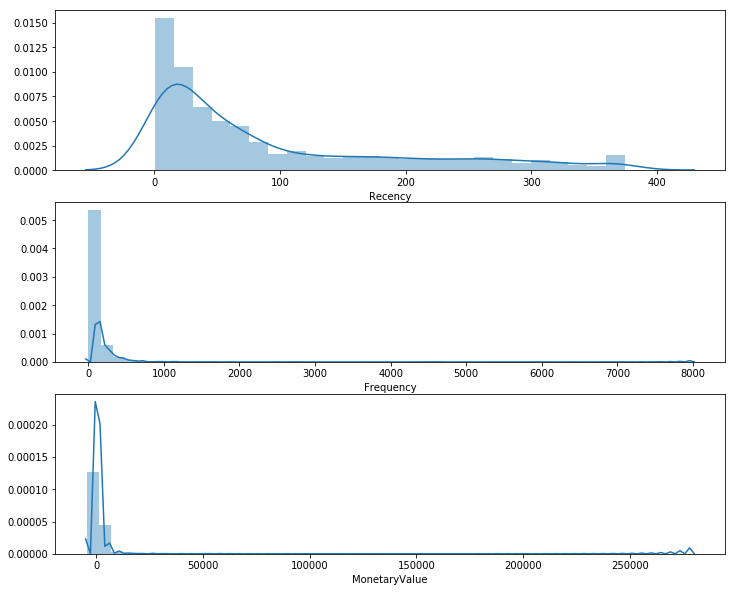

In [9]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
plt.show()

### Посчитаем группы R и F

In [20]:
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# q - количество групп (4)
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)

data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment_Concat  \
CustomerID                                                                  
12346.0         326          2           0.00  1  1  1                111   
12347.0           2        182        4310.00  4  4  4                444   
12348.0          75         31        1797.24  2  2  4                224   
12349.0          19         73        1757.55  3  3  4                334   
12350.0         310         17         334.40  1  1  2                112   

            RFM_Score           RFM_Level  
CustomerID                                 
12346.0           3.0  Require Activation  
12347.0          12.0    Can't Loose Them  
12348.0           8.0           Champions  
12349.0          10.0    Can't Loose Them  
12350.0           4.0     Needs Attention

### Посчитаем группу M

In [21]:
m_labels = range(1, 5)
# q - количество групп (4)
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
data_process = data_process.assign(M = m_groups.values)

### Объединим все в сегменты RFM

In [22]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process

rfm.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment_Concat  \
CustomerID                                                                  
12346.0         326          2           0.00  1  1  1                111   
12347.0           2        182        4310.00  4  4  4                444   
12348.0          75         31        1797.24  2  2  4                224   
12349.0          19         73        1757.55  3  3  4                334   
12350.0         310         17         334.40  1  1  2                112   

            RFM_Score           RFM_Level  
CustomerID                                 
12346.0           3.0  Require Activation  
12347.0          12.0    Can't Loose Them  
12348.0           8.0           Champions  
12349.0          10.0    Can't Loose Them  
12350.0           4.0     Needs Attention

In [23]:
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

62


In [24]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustomerID
12346.0     3.0
12347.0    12.0
12348.0     8.0
12349.0    10.0
12350.0     4.0
Name: RFM_Score, dtype: float64


In [25]:
# Объявим сегменты RFM
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
    
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment_Concat  \
CustomerID                                                                  
12346.0         326          2           0.00  1  1  1                111   
12347.0           2        182        4310.00  4  4  4                444   
12348.0          75         31        1797.24  2  2  4                224   
12349.0          19         73        1757.55  3  3  4                334   
12350.0         310         17         334.40  1  1  2                112   

            RFM_Score           RFM_Level  
CustomerID                                 
12346.0           3.0  Require Activation  
12347.0          12.0    Can't Loose Them  
12348.0           8.0           Champions  
12349.0          10.0    Can't Loose Them  
12350.0           4.0     Needs Attention

### Посчитаем средние значения для каждого RFM уровня и вернем размеры каждого сегмента

In [26]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't Loose Them      25.2     195.1        4130.3  1690
Champions             62.7      57.0         974.7   467
Loyal                 78.8      39.7         724.2   447
Needs Attention      174.5      13.9         227.1   391
Potential             94.3      28.5         491.8   468
Promising            153.0      21.2         346.8   517
Require Activation   264.8       7.8         109.1   392


In [27]:
'''
Потенциальные — высокий потенциал стать лояльными клиентами

Перспективные — показывали хорошие количество и стоимость покупок,
но прошло много времени с тех пор, как они в последний раз покупали. 

Требуют внимания — сделал некоторые первоначальные покупки, но с тех пор не активный.

Требуют активации — самые бедные клиенты по нашей модели RFM. Они могут уйти к нашим конкурентам 
и потребуется другая стратегия, чтобы вернуть их.
'''

'\nПотенциальные — высокий потенциал стать лояльными клиентами\n\nПерспективные — показывали хорошие количество и стоимость покупок,\nно прошло много времени с тех пор, как они в последний раз покупали. \n\nТребуют внимания — сделал некоторые первоначальные покупки, но с тех пор не активный.\n\nТребуют активации — самые бедные клиенты по нашей модели RFM. Они могут уйти к нашим конкурентам \nи потребуется другая стратегия, чтобы вернуть их.\n'

### Визуализируем сегменты

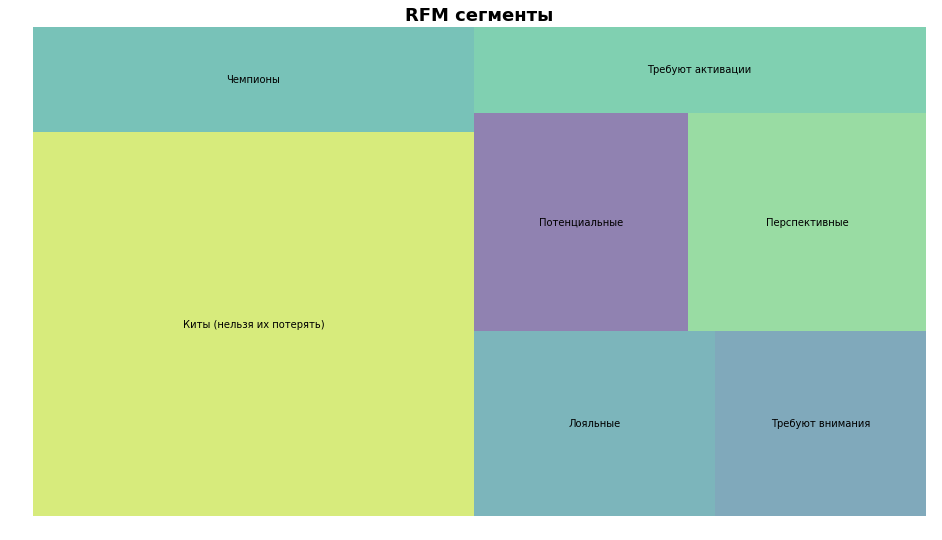

In [28]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Киты (нельзя их потерять)',
                     'Чемпионы',
                     'Лояльные',
                     'Требуют внимания',
                     'Потенциальные', 
                     'Перспективные', 
                     'Требуют активации'], alpha=.6 )
plt.title("RFM сегменты",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()